1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg as la

In [12]:
N = 1000
mu = 0
sigma = 1

x1 = np.random.normal(loc = mu, scale = sigma, size = N)

mu2 = 0
sigma2 = 3
x2 = np.random.normal(loc=mu2, scale = sigma2, size = N)

x3 = 2*x1+x2
X = [x1, x2, x3]

#eigenvalue and eigenvector
C = np.cov(X)
l,V = np.linalg.eig(C)

print("Eigenvalue:", l)
print("Normalised eigenvector:", V)

#eigenvalue and eigenvectors with SVD

U, spectrum, V = la.svd(C)
print("U\n:", U)
print("Spectrum (D)\n:", spectrum)
print("V\n:", V)

Eigenvalue: [ 2.23514664e+01 -2.35141382e-16  2.84418858e+00]
Normalised eigenvector: [[-0.0865693  -0.81649658  0.57082317]
 [-0.61254345 -0.40824829 -0.67684847]
 [-0.78568204  0.40824829  0.46479787]]
U
: [[-0.0865693   0.57082317 -0.81649658]
 [-0.61254345 -0.67684847 -0.40824829]
 [-0.78568204  0.46479787  0.40824829]]
Spectrum (D)
: [2.23514664e+01 2.84418858e+00 5.93955853e-16]
V
: [[-0.0865693  -0.61254345 -0.78568204]
 [ 0.57082317 -0.67684847  0.46479787]
 [ 0.81649658  0.40824829 -0.40824829]]


In [13]:
main_component = spectrum[0]/spectrum.sum()
print("Percent of variability, main component:", main_component*100)
per_tf = (spectrum[0]+spectrum[1]) /spectrum.sum()
print("Percent of variability, two features:", per_tf)

Percent of variability, main component: 88.71159101739904
Percent of variability, two features: 1.0


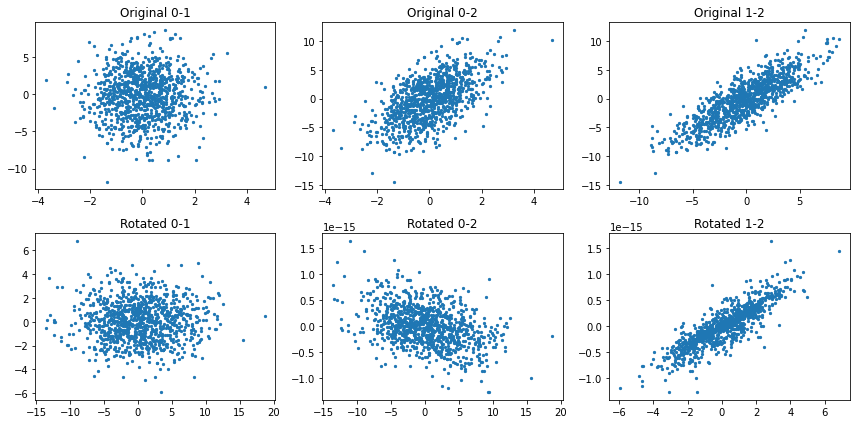

In [14]:
Xp = np.dot(V, X)
fig, axes = plt.subplots(nrows=2, ncols=3,
                               figsize=(12, 6))

#print(axes)
[[ax01, ax02, ax03],[ax11, ax12, ax13]] = axes

ax01.scatter(X[0], X[1], s= 5)
ax01.set_title('Original 0-1')
ax02.scatter(X[0], X[2], s= 5)
ax02.set_title('Original 0-2')
ax03.scatter(X[1], X[2], s= 5)
ax03.set_title('Original 1-2')

ax11.scatter(Xp[0], Xp[1], s= 5)
ax11.set_title('Rotated 0-1')
ax12.scatter(Xp[0], Xp[2], s= 5)
ax12.set_title('Rotated 0-2')
ax13.scatter(Xp[1], Xp[2], s= 5)
ax13.set_title('Rotated 1-2')

plt.tight_layout()
plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [17]:
X2 = np.zeros((13, N))
X2[0:3] = X
print(multiX.shape)

sigma3 = 1/50

for i in range(3,13):
    X2[i] = np.random.normal(scale = sigma3, size = N)
    
C1 = np.cov(X2)
U2, spectrum2, V2 = la.svd(C1)
print("Spectrum\n", spectrum2)
per_tf2 = (spectrum2[0]+spectrum2[1]) /spectrum2.sum()
print("Percent of variability, two features:", per_tf2)

(1000, 13)
Spectrum
 [2.23514712e+01 2.84419259e+00 4.80185213e-04 4.64491244e-04
 4.51267877e-04 4.15126803e-04 3.99642014e-04 3.91653455e-04
 3.84772437e-04 3.82361150e-04 3.64153763e-04 3.37799370e-04
 5.32707377e-17]
Percent of variability, two features: 0.999838432694545


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


In [77]:
N = 1000 # Total number of samples
t = np.linspace(0,2*np.pi,N)
spring_x = np.sinh(t)
noise_y = np.random.normal(loc=0, scale=0.1, size=N) # Little noise

v = np.array([
    np.sin(2*np.pi*t), # x
    np.random.normal(loc=0.0, scale=0.01, size=(N)), # y
    np.zeros(N) # z
    ])

samples = 3
theta = np.linspace(0,np.pi/2,samples)
phi = np.linspace(0,np.pi/2,samples)
cameras_coord = np.zeros((samples**2,2))
rotated_spring = np.zeros((samples**2,N,3))
print(cameras_theta.shape)
print(cameras_phi.shape)

(3,)
(3,)


In [78]:
i=0
for t in theta:
    for p in phi:
        y_rotation = np.array([[np.cos(p), 0, np.sin(p)], [0, 1, 0], [-np.sin(p), 0, np.cos(p)]])
        z_rotation = np.array([[np.cos(t), np.sin(t), 0], [-np.sin(t), np.cos(t), 0], [0, 0, 1]])

        rot = z_rotation.dot(y_rotation)
            # Apply the rotation to the original data
        rotated_spring[i] = rot.dot(v).T
        cameras_coord[i] = np.array([t, p])
        i += 1

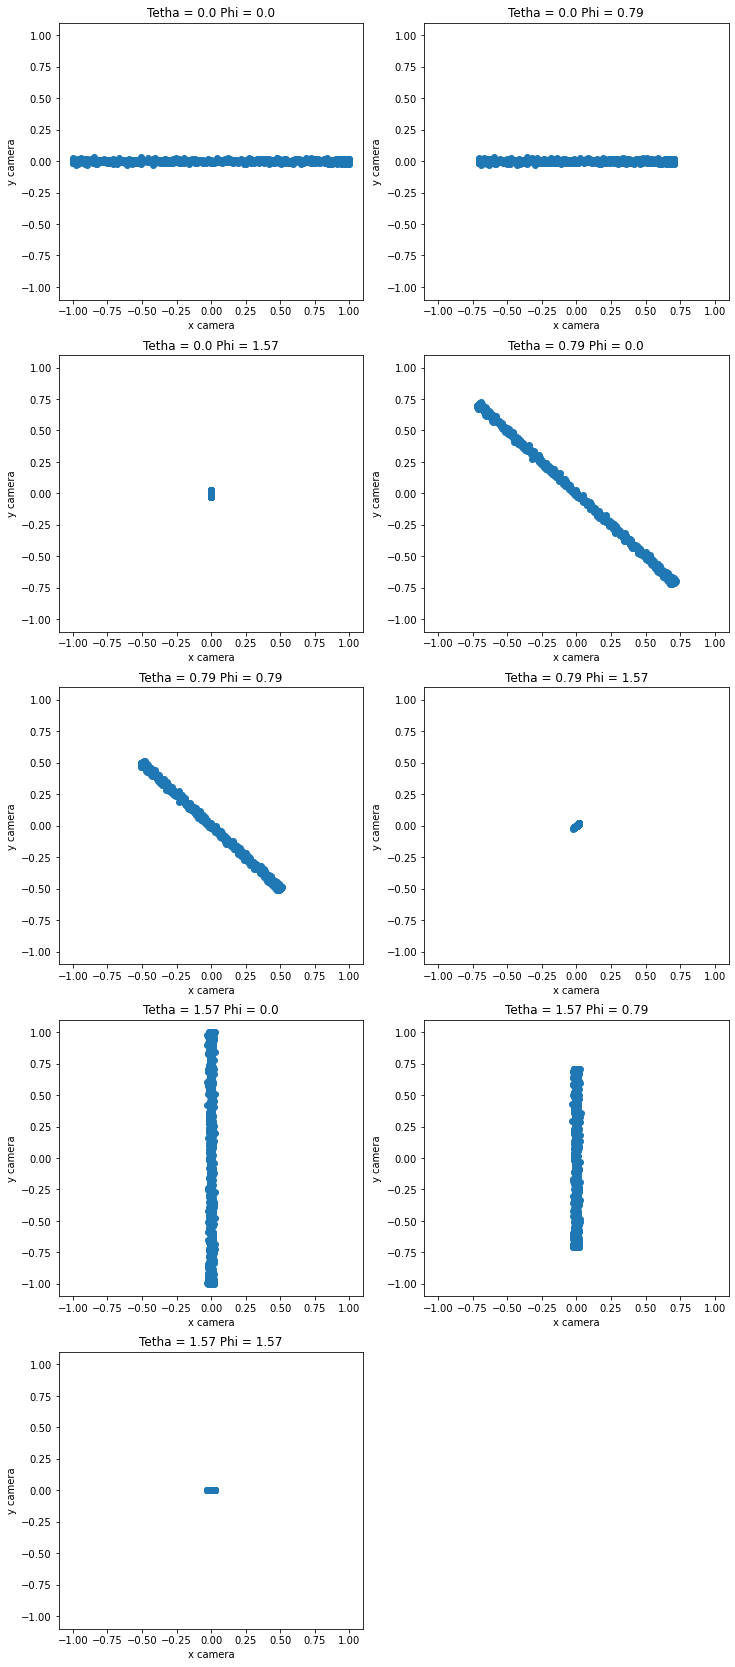

In [81]:
cols = 2
rows = np.ceil(samples**2)
plt.figure(figsize = (12,6*rows))
for k in range(1,samples**2+1):
    plt.subplot(rows,cols,k)
    plt.scatter(rotated_spring[k-1,:,0],rotated_spring[k-1,:,1])
    plt.xlabel("x camera")
    plt.ylabel("y camera")
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.title("Tetha = " + str(round(cameras_coord[k-1,0],2)) + 
              " Phi = " + str(round(cameras_coord[k-1,1],2)))

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [18]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

--2020-11-24 15:13:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Risoluzione di archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connessione a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 1477391 (1,4M) [application/x-httpd-php]
Salvataggio in: "/Users/carlotta/data/magic04.data"

magic04.data        100%[===================>]   1,41M   243KB/s    in 5,9s    

2020-11-24 15:13:20 (243 KB/s) - "/Users/carlotta/data/magic04.data" salvato [1477391/1477391]

--2020-11-24 15:13:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
Risoluzione di archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connessione a archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 5400 (5,3K) [application/x-httpd-php]
Salvataggio in: "/Users/

In [31]:
import os

file_name = './data/magic04.data'
#names = './data/magic04.names'
#file = open(names, 'r')
#names = file.readlines()

df = pd.read_csv(file_name, names=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','fCategory'])

In [33]:
#remove last column because it is a char
df = df = df.iloc[:, :-1]
df

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620
...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166


In [45]:
data_cov = np.cov(df.T)
U, spectrum, Vt = la.svd(data_cov)
eigs_sum = np.sum(spectrum)

print ("Variability principal component:\n",spectrum/eigs_sum)
print ("Variability main eigenvalues:\n",spectrum[:3].sum()/eigs_sum)

Variability principal component:
 [4.40472832e-01 2.57990739e-01 1.34983305e-01 8.88176474e-02
 4.08479378e-02 2.90265516e-02 7.85446025e-03 5.78367077e-06
 7.18728859e-07 2.57947768e-08]
Variability main eigenvalues:
 0.8334468747519855


(6579.791399778602+0j) [ 3.27812305e-01  1.13810001e-01  3.06076690e-03 -9.27109146e-04
 -5.21882399e-04 -3.80700011e-01 -7.16522956e-02  3.37405774e-03
 -5.35411190e-02  8.52426707e-01]
(3853.870481819947+0j) [ 1.34406332e-01  5.38837224e-02 -6.59372017e-04  2.58205308e-04
  1.52710005e-04 -6.93897410e-01 -5.62620169e-01  1.03235567e-03
  1.18351409e-01 -4.08641365e-01]
(2016.3831284182884+0j) [-6.55078481e-02  1.89938175e-02 -1.05931761e-03  5.10399700e-04
  2.94635944e-04  5.40076835e-01 -8.13121108e-01  1.24715329e-02
  5.31065391e-02  1.98800703e-01]
(1326.7596783587828+0j) [-0.86398825 -0.31976648 -0.00693029  0.00260555  0.00151276 -0.28513022
 -0.07588446 -0.01189481 -0.09251386  0.23549647]
(610.1872593818977+0j) [-9.45511967e-02  1.97548493e-02 -2.65185255e-03  1.53899865e-03
  9.19340567e-04  5.48387919e-03  1.02210804e-01  9.75590040e-03
  9.84242210e-01  1.06557705e-01]
(433.59917117483803+0j) [ 1.98552026e-02 -2.32592322e-02 -1.33441545e-04  3.46437681e-05
  2.21501607e-0

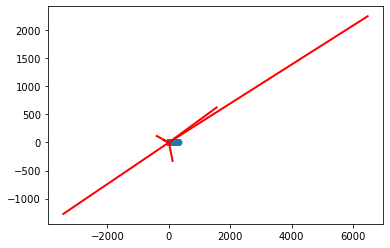

In [44]:
plt.scatter(df['fLength'], df['fSize'], alpha=0.2)
for li, vi in zip(l, V.T):
    print (li, vi)
    # the line is defined by means of its beginning and its end 
    plt.plot([0, scale_factor*li*vi[0]], [0, scale_factor*li*vi[1]], 'r-', lw=2)
